In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

INPUT_SIZE = 784
OUTPUT_SIZE = 10
BATCH_SIZE = 100
LEARNING_RATE = 0.5
ITERATIONS_BATCHES = 10000


train_set = datasets.MNIST(root="data", download=True, transform=ToTensor())
test_set = datasets.MNIST(root="data",
                          download=True,
                          transform=ToTensor(),
                          train=False)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)




torch.Size([10, 784])
torch.Size([10])
OrderedDict({'linear.weight': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), 'linear.bias': tensor([-0.0957,  0.3096, -0.0796, -0.1107,  0.1321,  0.2241,  0.0178,  0.2086,
        -0.5129, -0.0932])})


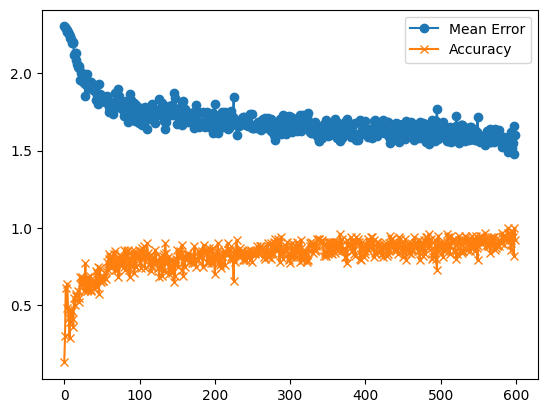

In [3]:
# Linear Model:
# for a linear model we need input and output dimension
import torch.nn as nn
import torch.optim as optim
from typing import Callable
import matplotlib.pyplot as plt

'''
The Softmax function : 
     Also called: softargmax or normalized exponential function.
     It converts a vector of K real numbers into a probability distribution of K possible outcomes.
     ==> for the multiclass classification
'''

class LinearModel(nn.Module):
     def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=input_size, out_features=output_size, bias=True)
        self.linear.weight.data = self.init_weights(input_size)
        self.linear.bias.data = self.init_bias(output_size)
        print(self.linear.weight.shape)
        print(self.linear.bias.shape)
        self.softmax = nn.Softmax(dim=1)
     
     def forward(self, x : torch.tensor):
          return self.linear(x)
     
     # we will use a softmax normalization
     def normalize(self, pred : torch.tensor):
          return self.softmax(pred)
     
     def flatten_batch_input(self, input_batch : torch.tensor)-> torch.tensor:
          flattened = input_batch.flatten(start_dim=1)
          return flattened
     
     def init_weights(self, input_size : int) -> torch.tensor:
          lists = [[0.0]*input_size for x in range(10) ]
          return torch.tensor(lists)

     def init_bias(self, output_size) -> torch.tensor:
          bias = [0.0] * output_size
          return torch.tensor(bias)
     
     # gives back the ratio between correctly classified and batch size
     def calculate_accuracy(self, pred: torch.tensor, actual : torch.tensor):
          counter_acc = 0
          counter = 0
          for row in pred:
               max_ind = torch.argmax(row)
               if max_ind == actual[counter]:
                    counter_acc += 1
               counter += 1
          
          return counter_acc / len(pred)


def train_linear_model(
          model : LinearModel,
          error_function : Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
          dataloader : DataLoader
                    ) -> list[float]:
     optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
     errors = []
     accuracies = []
     iterations_counter = 0
     epochs_counter = 0
     while iterations_counter < ITERATIONS_BATCHES:
          for batch, labels in dataloader:
               flat = model.flatten_batch_input(batch)
               out =  model.forward(flat)
               out_normalized = model.normalize(out)
               accuracy = model.calculate_accuracy(out_normalized, labels)
               loss = error_function(out_normalized, labels)
               optimizer.zero_grad()
               loss.backward() 
               optimizer.step()
               errors.append(loss.item())
               accuracies.append(accuracy)
               iterations_counter += BATCH_SIZE
          epochs_counter += 1
     
     return errors, accuracies, epochs_counter

def save_model_dict(model, PATH) -> None: 
     print(model.state_dict())
     torch.save(model.state_dict(), PATH)

def load_model(PATH, model : nn.Module):
     state_dict = torch.load(PATH)
     model.load_state_dict(state_dict)
     return model

     
model = LinearModel(INPUT_SIZE, OUTPUT_SIZE)
model.init_weights(INPUT_SIZE)

errors_linear_model, acc, number_epochs = train_linear_model(model, nn.CrossEntropyLoss(), train_loader)

save_model_dict(model, "./models/linearModel.pt" )

def plot_linear_model(errors, acc):
     x_axis = list(range(len(errors)))
     plt.plot(x_axis, errors, label='Mean Error', marker='o')
     plt.plot(x_axis, acc , label='Accuracy', marker='x' )
     plt.legend()
     plt.show()

plot_linear_model(errors_linear_model, acc)



In [24]:
linear_model_loaded = load_model("./models/linearModel.pt", LinearModel(INPUT_SIZE, OUTPUT_SIZE))
print("Model Parameters:")
for name, param in model.state_dict().items():
    print(f"{name}: {param.size()}")
    print(param)

torch.Size([10, 784])
torch.Size([10])
Model Parameters:
linear.weight: torch.Size([10, 784])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
linear.bias: torch.Size([10])
tensor([-0.0957,  0.3096, -0.0796, -0.1107,  0.1321,  0.2241,  0.0178,  0.2086,
        -0.5129, -0.0932])


C:\Users\jojog\AppData\Local\Temp\ipykernel_19628\2363303018.py:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return model.load_state_dict(torch.load(PATH))


In [3]:
# functions for custom initializing weights
import numpy as np

def is_too_far(rand : float, mean: float, std : float) -> bool:
     upper = mean + 2 * std
     lower = mean - 2 * std
     return  (rand > upper or rand < lower)
          

def truncated_normal_two_std(x : int, y : int, mean : float , std : float)-> nn.Parameter:
     two_dim_arr = [[0.0] * y for _ in range(x)]
     for x in range(len(two_dim_arr) -1 ):
          for y in range(len(two_dim_arr[x]) -1):
               sample = np.random.normal(mean, std)
               while is_too_far(sample, mean=mean, std=std):
                    sample = np.random.normal(mean, std)

               two_dim_arr[x][y] = sample
     
     return nn.Parameter(torch.tensor(two_dim_arr), requires_grad=True)

     

def init_bias_with_constant(height : int) -> nn.Parameter:
     ten=  torch.tensor([(-0.1) ** 5.0 for _ in range(height)])
     return nn.Parameter(ten, requires_grad=True)

#print(truncated_normal_two_std(5, 5, 0, 0.01))
#print(init_bias_with_constant(10))


# The Adam Algorithm (Adaptive moment Estimation)

- a method for efficient stochastic optimization that only requires first order gradients
- stochasticity comes from: evaluation at random subsamples (minibatches) or noise
- the algorithm updates exponential moving averages of the gradient and the squared gradient
- the hyper parameters beta 1, 2 control the exponential decay of the moving averages

The amount of layers after initialization 4


c:\Users\jojog\Documents\Archiv\Studium\Master Studium Berlin\Machine_Intelligence1\Machine_Intelligence1\venv\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


OrderedDict({'layers.0.weight': tensor([[ 0.0135,  0.0169,  0.0029,  ...,  0.0104,  0.0073, -0.0063],
        [-0.0101, -0.0210,  0.0074,  ...,  0.0037, -0.0152, -0.0045],
        [-0.0170, -0.0089, -0.0150,  ..., -0.0005,  0.0004, -0.0189],
        ...,
        [-0.0007,  0.0035,  0.0102,  ..., -0.0035,  0.0275, -0.0035],
        [ 0.0081,  0.0038,  0.0026,  ...,  0.0038, -0.0170, -0.0016],
        [-0.0066, -0.0021,  0.0137,  ..., -0.0075,  0.0099, -0.0188]]), 'layers.0.bias': tensor([-1.0139e-02, -5.0352e-02, -1.1834e-03,  ..., -7.4332e-05,
         5.5822e-02, -5.9921e-02]), 'layers.1.weight': tensor([[-0.0224, -0.0335, -0.1079,  ..., -0.0539, -0.0466, -0.0329],
        [-0.0350, -0.0565, -0.0693,  ..., -0.0318, -0.0721, -0.0206],
        [-0.0086, -0.0095, -0.0800,  ...,  0.0013, -0.1307, -0.0041],
        ...,
        [ 0.0050, -0.0678,  0.0664,  ..., -0.0151, -0.0246, -0.0410],
        [-0.0043, -0.0148, -0.0159,  ..., -0.0028,  0.0156,  0.0376],
        [ 0.0144, -0.0152, -0.00

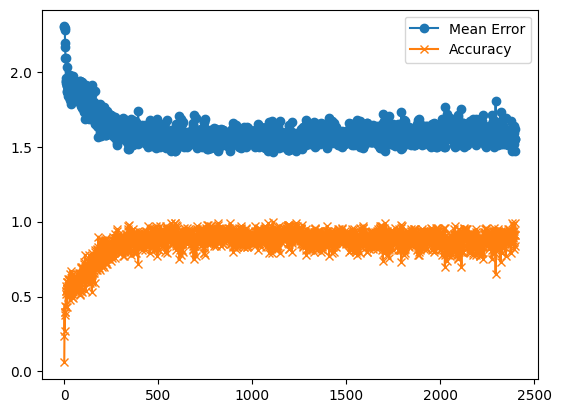

In [26]:
'''
A second model: MLP with 3 Hidden Layers and 1500 

Weights and Biases will be initilazed with the functions above.

We use ReLu as an activation function for the Hidden layers.

We use Softmax as a normalization at the outputlayer
'''
import torch.nn.init as init

class MLP(nn.Module):

        def __init__(self, loss_function : Callable,   dimensions : list[int], activations : list[Callable], mean_weight :float, std_weight: float):
                super(MLP, self).__init__()
                self.loss_function = loss_function
                self.mean_weight = mean_weight
                self.std_weight = std_weight
                # in the input layer there is no activation
                assert len(activations) == len(dimensions) -1
                self.activations = activations
                self.layers = self.init_model_layers(dimensions=dimensions)


        def init_model_layers(self, dimensions : list[int])-> nn.ModuleList:
                layers = nn.ModuleList()
                for idx in range(1, len(dimensions)):
                        new_layer = nn.Linear(in_features=dimensions[idx -1],out_features=dimensions[idx],  bias=True)
                        self.init_weights(new_layer)
                        self.init_bias(new_layer)
                        layers.append(new_layer)
                print(f"The amount of layers after initialization {len(layers)}")
                return layers

        def forward(self, input : torch.tensor) -> torch.tensor:
                for index in range(len(self.layers)):
                        input = self.layers[index](input)
                        input = self.activations[index](input)
                return input
        
        def flatten_batch_input(self, input_batch : torch.tensor)-> torch.tensor:
                flattened = input_batch.flatten(start_dim=1)
                return flattened
        
        def init_weights(self, layer: nn.Linear):
                init.trunc_normal_(layer.weight, mean=self.mean_weight, std=self.std_weight, a=-2, b=2)

        def init_bias(self, layer: nn.Linear):
                if isinstance(layer, nn.Linear):
                        init.constant_(layer.bias, (-0.1) ** 5.0)
        
        # gives back the ratio between correctly classified and batch size
        def calculate_accuracy(self, pred: torch.tensor, actual : torch.tensor):

          counter_acc = 0
          counter = 0
          for row in pred:
               max_ind = torch.argmax(row)
               if max_ind == actual[counter]:
                    counter_acc += 1
               counter += 1
          
          return counter_acc / len(pred)
        

def train_MLP_model(mlp_model : MLP, train_loader : DataLoader , iterations : int) -> tuple[list[float], list[float]]:
        # initlaized with the standard parameters
        optimizer = optim.Adam(mlp_model.parameters(), lr=0.001 )

        errors = []
        accuracies = []
        iterations_counter = 0
        while iterations_counter < iterations:
                for batch, labels in train_loader:
                        flat = mlp_model.flatten_batch_input(batch)
                        optimizer.zero_grad()
                        out =  mlp_model.forward(flat)
                        accuracy = mlp_model.calculate_accuracy(out, labels)
                        loss = mlp_model.loss_function(out, labels)
                        loss.backward() 
                        optimizer.step()
                        errors.append(loss.item())
                        accuracies.append(accuracy)
                        iterations_counter += 1

        return errors, accuracies


MEAN_WEIGHT = 0.0
WEIGHT_STD = 0.01

mlp_model = MLP(nn.CrossEntropyLoss(), [784, 1500, 1500, 1500, 10], [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.Softmax()], MEAN_WEIGHT, std_weight=WEIGHT_STD)
#print(list(mlp_model.parameters()))
errors, accuracies = train_MLP_model(mlp_model,train_loader, 2000)

save_model_dict(mlp_model, "./models/mlpModel.pt")

plot_linear_model(errors=errors, acc=accuracies)

     

# Dropout

Dropout is a regularization technique. For large feed forward neural nets.
- If large feedforward nets are trained on "small" training sets, it typically perfroms bad on held-out test data.
- this overfitting is greatly reduced by omitting half of the feature detectors on each training case.
- if the network has enough hidden units, a lot of weight combination can model the relationship between input and output perfectly
- with a probability from 0.5 hidden units are omitted from the feedforward process. to prevent co adaptions between hidden neurons
- dropout can also be seen: as model averaging
     - to redcue the test error : train several models and average the test error (extreme computationall expensive)
     - with dropout you can train huge amount of networks in a reasonable time



In [29]:

# Normal stochastic gradient descent for the training

class MLPDropOut(nn.Module):

     def __init__(self, loss_function : Callable,   dimensions : list[int], activations : list[Callable], mean_weight :float, std_weight: float):
                super(MLPDropOut, self).__init__()
                self.loss_function = loss_function
                self.mean_weight = mean_weight
                self.std_weight = std_weight
                # in the input layer there is no activation
                assert len(activations) == len(dimensions) -1
                self.activations = activations
                self.layers = self.init_model_layers(dimensions=dimensions)
                self.dropout = nn.Dropout(p=0.5)

     def init_model_layers(self, dimensions : list[int])-> nn.ModuleList:
                layers = nn.ModuleList()
                for idx in range(1, len(dimensions)):
                        new_layer = nn.Linear(in_features=dimensions[idx -1],out_features=dimensions[idx],  bias=True)
                        self.init_weights(new_layer)
                        self.init_bias(new_layer)
                        layers.append(new_layer)
                print(f"The amount of layers after initialization {len(layers)}")
                return layers

     def forward(self, input : torch.tensor) -> torch.tensor:
                for index in range(len(self.layers)):
                        if index < len(self.layers) -1:
                                # everything except the output transformation
                                input = self.dropout(input)
                        input = self.layers[index](input)
                        input = self.activations[index](input)
                return input
        
     def flatten_batch_input(self, input_batch : torch.tensor)-> torch.tensor:
                flattened = input_batch.flatten(start_dim=1)
                return flattened
        
     def init_weights(self, layer: nn.Linear):
                init.trunc_normal_(layer.weight, mean=self.mean_weight, std=self.std_weight, a=-2, b=2)

     def init_bias(self, layer: nn.Linear):
                if isinstance(layer, nn.Linear):
                        init.constant_(layer.bias, (-0.1) ** 5.0)
        
        # gives back the ratio between correctly classified and batch size
     def calculate_accuracy(self, pred: torch.tensor, actual : torch.tensor):

          counter_acc = 0
          counter = 0
          for row in pred:
               max_ind = torch.argmax(row)
               if max_ind == actual[counter]:
                    counter_acc += 1
               counter += 1
          
          return counter_acc / len(pred)


def train_MLP_dropout_model(mlp_drop_out_model : MLPDropOut, train_loader : DataLoader , iterations : int) -> tuple[list[float], list[float]]:
        # initlaized with the standard parameters
        optimizer = optim.Adam(mlp_drop_out_model.parameters(), lr=0.001 )

        errors = []
        accuracies = []
        iterations_counter = 0
        while iterations_counter < iterations:
                for batch, labels in train_loader:
                        flat = mlp_drop_out_model.flatten_batch_input(batch)
                        optimizer.zero_grad()
                        out =  mlp_drop_out_model.forward(flat)
                        if iterations_counter % 100 == 0:
                                accuracy = mlp_drop_out_model.calculate_accuracy(out, labels)
                                accuracies.append(accuracy)
                        loss = mlp_drop_out_model.loss_function(out, labels)
                        loss.backward() 
                        optimizer.step()
                        errors.append(loss.item())
                        iterations_counter += 1

        return errors, accuracies


mlp_dropout = MLPDropOut(nn.CrossEntropyLoss(), [784, 1500, 1500, 1500, 10], [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.Softmax()], MEAN_WEIGHT, std_weight=WEIGHT_STD)

train_MLP_dropout_model(mlp_dropout, train_loader=train_loader, iterations=2000)

save_model_dict(mlp_dropout, "./models/mlpModelDropout.pt")
               

The amount of layers after initialization 4


c:\Users\jojog\Documents\Archiv\Studium\Master Studium Berlin\Machine_Intelligence1\Machine_Intelligence1\venv\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


OrderedDict({'layers.0.weight': tensor([[ 0.0026, -0.0107, -0.0034,  ..., -0.0152, -0.0059, -0.0065],
        [ 0.0110,  0.0038, -0.0012,  ..., -0.0094,  0.0162,  0.0135],
        [-0.0145,  0.0027, -0.0083,  ...,  0.0058,  0.0030,  0.0074],
        ...,
        [-0.0002,  0.0051,  0.0166,  ..., -0.0018, -0.0047,  0.0014],
        [ 0.0029,  0.0069, -0.0111,  ..., -0.0144, -0.0057, -0.0072],
        [-0.0145,  0.0018,  0.0016,  ..., -0.0021,  0.0084, -0.0074]]), 'layers.0.bias': tensor([ 0.0112, -0.0160, -0.0136,  ..., -0.0470, -0.0187, -0.0077]), 'layers.1.weight': tensor([[-0.0375,  0.0031,  0.0135,  ..., -0.0353, -0.0250,  0.0236],
        [-0.0204,  0.0152,  0.0025,  ...,  0.0094, -0.0097, -0.0626],
        [-0.0426, -0.0203,  0.0098,  ..., -0.0548, -0.0359, -0.0581],
        ...,
        [-0.0014, -0.0146, -0.0471,  ..., -0.0650,  0.0433, -0.0389],
        [-0.0280,  0.0043, -0.0332,  ..., -0.0061, -0.0277,  0.0375],
        [-0.0162,  0.0053,  0.0161,  ..., -0.0206,  0.0361, -0.0

The amount of layers after initialization 4
The amount of layers after initialization 4
torch.Size([10, 784])
torch.Size([10])


C:\Users\jojog\AppData\Local\Temp\ipykernel_19628\3554884330.py:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(PATH)
c:\Users\jojog\Documents\Arch

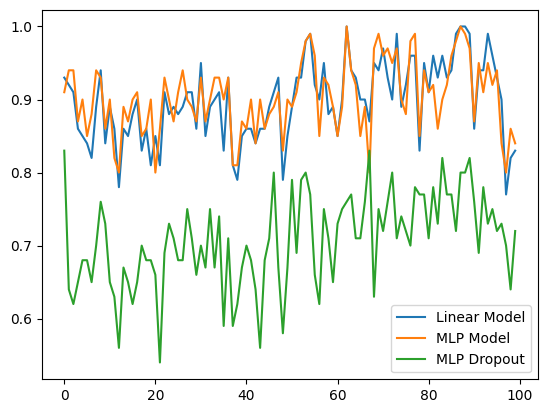

In [36]:
'''
Validating the Models
'''
PATH_LINEAR_MODEL = "./models/linearModel.pt"

PATH_DROP_OUT_MODEL = "./models/mlpModelDropout.pt"

PATH_MLP_MODEL = "./models/mlpModel.pt"


mlp_model_validation = load_model(PATH_MLP_MODEL, MLP(nn.CrossEntropyLoss(), [784, 1500, 1500, 1500, 10], [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.Softmax()], MEAN_WEIGHT, std_weight=WEIGHT_STD))

mlp_drop_out_model_validation = load_model(PATH_DROP_OUT_MODEL, MLPDropOut(nn.CrossEntropyLoss(), [784, 1500, 1500, 1500, 10], [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.Softmax()], MEAN_WEIGHT, std_weight=WEIGHT_STD))

linear_model_validation = load_model(PATH_LINEAR_MODEL, LinearModel(INPUT_SIZE, OUTPUT_SIZE))


models = [linear_model_validation, mlp_model_validation, mlp_drop_out_model_validation]

def validate_model(model : nn.Module, test_loader : DataLoader ):
     test_accuracy = []
     model.eval()
     with torch.no_grad():
          for batch, labels in test_loader:
               flat = model.flatten_batch_input(batch)
               out = model.forward(flat)
               accuracy = mlp_model.calculate_accuracy(out, labels)
               test_accuracy.append(accuracy)
     
     return test_accuracy

model_accuracies = []
for model in models:
     model_accuracies.append(validate_model(model, test_loader=test_loader))

def plot_accuracies(accuracies_lists : list[list[float]], model_names : list[str]) -> None:
     x_axis = list(range(len(accuracies_lists[0])))
     for x in range(len(model_names)):
          plt.plot(x_axis, accuracies_lists[x], label=model_names[x])
     
     plt.legend()
     plt.show()
               
  
plot_accuracies(accuracies_lists=model_accuracies, model_names=["Linear Model" , "MLP Model", "MLP Dropout"])



# Deep Learning Lecture and Tutorial Notes

- in deep neural networks, some weigts might get stuck
- it is prone to overfitting and not necessarily better than a 2 layer MLP
- the gradient might vanish or explode
     a simple example:
     - If we have 4 layers , and baclpropagate something, we still have to multiply a probably small number times 4 which will be a very small number


# Convoloutional Neural Network

- normal feed forward networks often cannoot handle the computational complexity of image data
- if ou have a 64 by 64 image with pixels then you would have to have 12288 input ndes alone....

- a lot of parameters -> prone to overfitting --> reducing complexity, the need for CNNs


# Architecture

- we need to reduce the image to a shape that is easier to process

- the nodes: nodes consists of three dimensions: height, widht and deptht

- there can be three types of layers in the CNNs:
     - convolution layers
     - pooling layers
     - fully-connected Layers

Images in the RBG model have three color channels

     - if it is black and white (like MINST Data) habe (28 x 28 x 1) meaning one channel and the pixel dimensions
     - color images have (X x X x 3) three color encodings 

Convolutional Layer:
- 



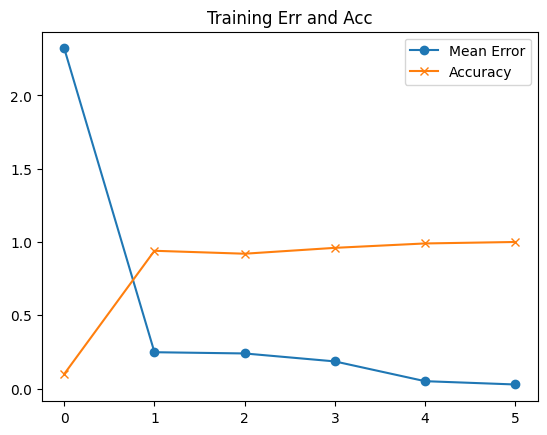

c:\Users\jojog\Documents\Archiv\Studium\Master Studium Berlin\Machine_Intelligence1\Machine_Intelligence1\venv\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


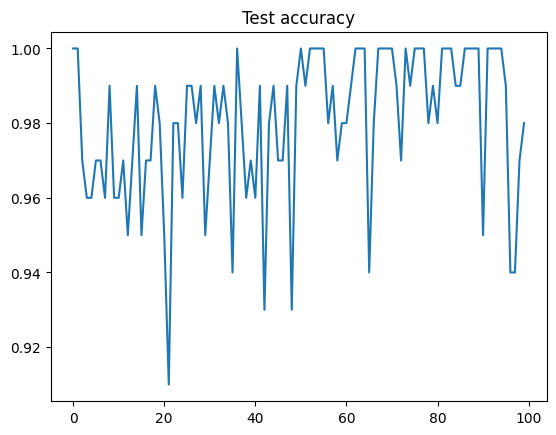

In [14]:


'''
In channels: the number of color codings for an Image: handwritten digits in MINST
out_channels: number of filters, each filter extracts a unique this is the number of matrices in a "cube" , the widht

spatial dimensions: height and width of tensors

Kernel Size : (5,5) dimensions of the matrix of the filter matrix
'''

class CNN(nn.Module):

     def __init__(self, loss_function : Callable):
          super(CNN, self).__init__()
          self.layers = self._init_layers()
          self.loss_function = loss_function

     def _init_layers(self) -> nn.ModuleList:
          modules = nn.ModuleList()
          modules.extend(self._convolution_layer(in_channels=1, out_channels=32, kernel_size=(5,5), stride=1, bias=True))
          modules.append(self._down_sampling(kernel_size=2, stride=(2,2)))
          modules.extend(self._convolution_layer(in_channels=32 , out_channels=64, kernel_size=(5,5), stride=1 , bias=True ))
          modules.append(self._down_sampling(kernel_size=2, stride=(2,2)))
          modules.extend(self._fully_connected(in_features=1024, out_features=10, bias=True))
          return modules

     def _convolution_layer(self, in_channels: int, out_channels : int, kernel_size : tuple[int, int], stride : int, bias : bool) -> nn.ModuleList:
          m_list = []
          conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, bias=bias)
          ac = nn.ReLU()
          m_list.append(conv_layer)
          m_list.append(ac)
          return m_list

     def _down_sampling(self, kernel_size : int, stride :tuple[int, int] ) -> nn.Module:
          layer = nn.MaxPool2d(kernel_size=kernel_size, stride=stride)
          return layer
     
     def _fully_connected(self, in_features : int , out_features : int, bias : bool) -> nn.ModuleList:
          m_list = nn.ModuleList()
          flat = nn.Flatten()
          layer = nn.Linear(in_features=in_features, out_features=out_features, bias=bias)
          m_list.append(flat)
          m_list.append(layer)
          return m_list

     def forward(self, input : torch.tensor) -> torch.tensor:
          #print(f"input befor {input.shape}")
          for layer in self.layers:
               input = layer(input)
              # print(f"after operation {input.shape}")
          return input
     
     def flatten_batch_input(self, input_batch : torch.tensor)-> torch.tensor:
          flattened = input_batch.flatten(start_dim=1)
          return flattened

     # gives back the ratio between correctly classified and batch size
     def calculate_accuracy(self, pred: torch.tensor, actual : torch.tensor):
          counter_acc = 0
          counter = 0
          for row in pred:
               max_ind = torch.argmax(row)
               if max_ind == actual[counter]:
                    counter_acc += 1
               counter += 1
          
          return counter_acc / len(pred)

     def train(self, iterations : int):
          # initlaized with the standard parameters
        optimizer = optim.Adam(self.parameters(), lr=0.001 )

        errors = []
        accuracies = []
        iterations_counter = 0
        while iterations_counter < iterations:
                for batch, labels in train_loader:
                        #flat = self.flatten_batch_input(batch)
                        optimizer.zero_grad()
                        out =  self.forward(batch)
                        loss = self.loss_function(out, labels)
                        if iterations_counter % 100 == 0:
                                accuracy = self.calculate_accuracy(out, labels)
                                accuracies.append(accuracy)
                                errors.append(loss.item())
                        loss.backward() 
                        optimizer.step()
                        iterations_counter += 1

        return errors, accuracies


my_cnn = CNN(nn.CrossEntropyLoss())
err, acc = my_cnn.train(3)

def plot_CNN_model(errors, acc):
     x_axis = list(range(len(errors)))
     plt.plot(x_axis, errors, label='Mean Error', marker='o')
     plt.plot(x_axis, acc , label='Accuracy', marker='x' )
     plt.title("Training Err and Acc")
     plt.legend()
     plt.show()

plot_CNN_model(err, acc)

def validate_CNN_model(model : CNN, test_loader : DataLoader):
     test_accuracy = []
     soft_max = nn.Softmax()
     model.eval()
     with torch.no_grad():
          for batch, labels in test_loader:
               #flat = model.flatten_batch_input(batch)
               out = model.forward(batch)
               out = soft_max(out)
               accuracy = model.calculate_accuracy(out, labels)
               test_accuracy.append(accuracy)
     
     return test_accuracy

accuracy = validate_CNN_model(my_cnn, test_loader=test_loader)

x_axis =  list(range(len(accuracy)))
plt.plot(x_axis, accuracy)
plt.title("Test accuracy")
plt.show()